# Beam ellipticity notebook and examples (part 2)

## Intro 
The notebook is built on the s4cmb_beam_ellipticity.ipynb notebook and shows some advanced usage of the beam mismatch leakage propagation from time domain to map. Some features might only be available in the dev branch.

In [1]:
import healpy as hp
import pylab as pl
import numpy as np
import os 

## Import modules and routines from s4cmb
from s4cmb.input_sky import HealpixFitsMap

from s4cmb.instrument import Hardware
from s4cmb.instrument import construct_beammap,construct_beammap, coordinates_on_grid,gauss2d

from s4cmb.scanning_strategy import ScanningStrategy

from s4cmb.tod import TimeOrderedDataPairDiff
from s4cmb.tod import OutputSkyMap
from s4cmb.tod import partial2full

from s4cmb.systematics import waferts_add_diffbeam
from s4cmb.systematics import get_kernel_coefficients
from s4cmb.systematics import inject_beam_ellipticity
from s4cmb.systematics import derivs
from s4cmb.systematics import modify_beam_offsets

try:
    from tqdm import *
except ImportError:
    tqdm = lambda x: x

# gets rid of warning when plotting beams
np.seterr(divide='ignore',invalid='ignore')

#set s4cmb path
for k in os.environ.keys():
    if 's4cmb' in k.lower():
        s4cmbpath=os.environ['s4cmbPATH']


In [2]:
## Instrument
inst = Hardware(ncrate=4, ndfmux_per_crate=1,
                nsquid_per_mux=1, npair_per_squid=16,
                fp_size=60., fwhm=3.5, 
                beam_seed=58347, projected_fp_size=3., pm_name='5params',
                type_hwp='CRHWP', freq_hwp=2., angle_hwp=0., verbose=False)

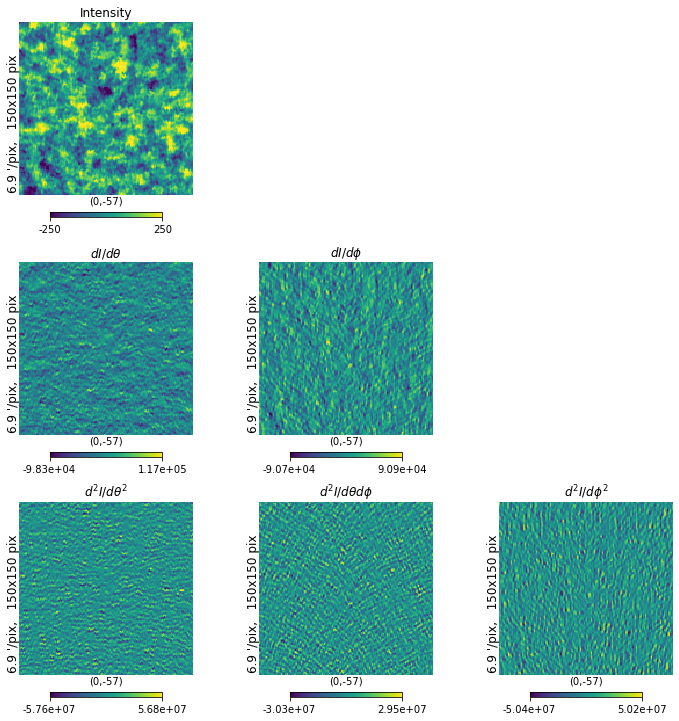

In [3]:

## Input maps
nside = 512
path_to_cls = os.path.join(s4cmbpath,'s4cmb/data/test_data_set_lensedCls.dat')
sky_in = HealpixFitsMap(path_to_cls, do_pol=True, 
                        fwhm_in=inst.beam_model.fwhm, nside_in=nside, 
                        map_seed=5843787, verbose=False, compute_derivatives=True,
                        no_ileak=False, no_quleak=False)

xsize=150
reso=6.9

pl.figure(figsize=(10, 10))
hp.gnomview(sky_in.I, rot=[0, -57], 
            xsize=xsize, reso=reso,
            title='Intensity',
            min=-250, max=250, sub=331)
hp.gnomview(sky_in.dIdt, rot=[0, -57], 
            title='$dI/d\\theta$',
            xsize=xsize, reso=reso, sub=334)
hp.gnomview(sky_in.dIdp, rot=[0, -57], 
            title='$dI/d\\phi$',
            xsize=xsize, reso=reso, sub=335)
hp.gnomview(sky_in.d2Id2t, rot=[0, -57], 
            title='$d^2I/d\\theta^2$',
            xsize=xsize, reso=reso, sub=337)
hp.gnomview(sky_in.d2Idpdt, rot=[0, -57], 
            title='$d^2I/d\\theta d\\phi$',
            xsize=xsize, reso=reso, sub=338)
hp.gnomview(sky_in.d2Id2p, rot=[0, -57], 
            title='$d^2I/d\\phi^2$',
            xsize=xsize, reso=reso, sub=339)
pl.show()

In [4]:
## Scanning strategy
scan = ScanningStrategy(nces=4, start_date='2013/1/1 00:00:00',
                        telescope_longitude='-67:46.816',
                        telescope_latitude='-22:56.396', telescope_elevation=5200.,
                        name_strategy='deep_patch', sampling_freq=8., sky_speed=0.4,
                        ut1utc_fn=os.path.join(s4cmbpath,'s4cmb/data/ut1utc.ephem'), 
                        language='fortran')
scan.run()

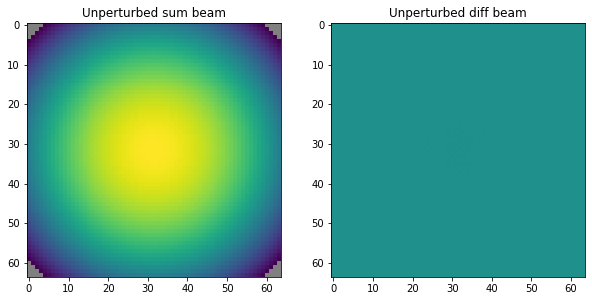

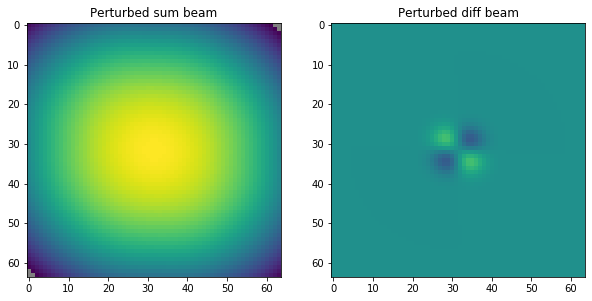

In [5]:
## Just for visualisation
fig, ax = pl.subplots(1, 2, figsize=(10, 5))
pix_size = 0.5 / 60. * np.pi / 180.
nx = 64

summap, diffmap = construct_beammap(inst.beam_model, 0, 1, nx, pix_size)
ax[0].imshow(np.log10(summap))#, vmin=0, vmax=1)
ax[0].set_title('Unperturbed sum beam')
ax[1].imshow(diffmap, vmin=-0.2, vmax=0.2)
ax[1].set_title('Unperturbed diff beam')
pl.show()


## Generate beam ellipticity (20% \pm 5%)
sig_1, sig_2, ellip_ang = inject_beam_ellipticity(
    inst.beam_model.sig_1[0], 10, 5, 
    inst.focal_plane.nbolometer, 
    do_diffbeamellipticity=True)



inst.beam_model.sig_1 = sig_1
inst.beam_model.sig_2 = sig_2
inst.beam_model.ellip_ang = ellip_ang

summap, diffmap = construct_beammap(inst.beam_model, 0, 1, nx, pix_size)
fig, ax = pl.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(np.log10(summap))#, vmin=0, vmax=1)
ax[0].set_title('Perturbed sum beam')
ax[1].imshow(diffmap, vmin=-0.1, vmax=0.1)
ax[1].set_title('Perturbed diff beam')

pl.show()

## Kernel coefficients

We compute here the kernel coefficients to eavluated the approximate beam leakage. As we are considering only
ellipticities differences as sources of beam mismatch, the major correction to the approximated beam projects on the
second derivatives of the beam, while the coefficients of the first derivatives are essentially zero. 

For the component projecting on the monopole the diff beam projects to 0 and therefore we added 1 to the corresponding value for plotting purposes. The monopole component does not project exactly to 1 for the sum beam showing that there is a power mismatch  (usually degenerate with an overall calibration mismatch). We thus included the option to do not include this component in the timestream simulations (see further down the "_nomonopole" keyword).

<Figure size 432x288 with 0 Axes>

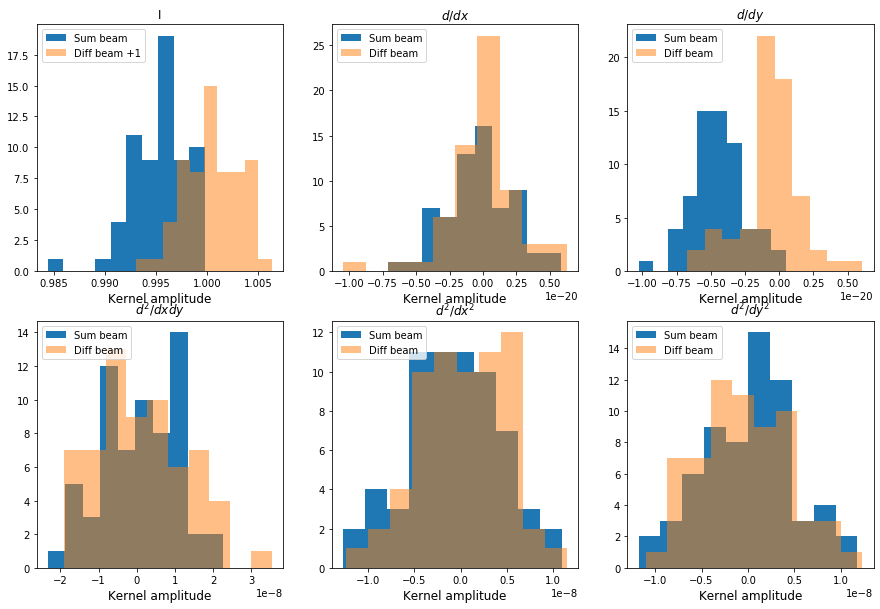

<Figure size 432x288 with 0 Axes>

In [34]:
npair = inst.focal_plane.npair
pair_list = np.reshape(
inst.focal_plane.bolo_index_in_fp, (npair, 2))

## For visualisation
Ktot = []
Ktot_sum=[]
Ktot_diff=[]
## Pre compute leakage runs pair-by-pair 
for pair in tqdm(pair_list):
    
    ## Compute beam kernel coefficients for both sum and diff beams or only diff beam using
    ## two different basis functions.
    Ksumdiff = get_kernel_coefficients(inst.beam_model, [pair],nx=200,kernel_type='sumdiff')
    K = get_kernel_coefficients(inst.beam_model, [pair],nx=200,kernel_type='diff',basis='sumbeam')    
    Ktot.append(K)
    Ktot_diff.append(Ksumdiff[0])
    Ktot_sum.append(Ksumdiff[1])
    
Ktot = np.array(Ktot)
Ktot_diff = np.array(Ktot_diff)
Ktot_sum = np.array(Ktot_sum)

fig,ax = pl.subplots(2,3,figsize=(15,10))
titles=['I','$d/dx$','$d/dy$','$d^2/dxdy$','$d^2/dx^2$','$d^2/dy^2$']
for i in range(2):
    for j in range(3):
        ax[i,j].hist(Ktot_sum[:,0,i*3+j],label='Sum beam')
        if (i==0 and j==0):
            ax[i,j].hist(Ktot_diff[:,0,i*3+j]+1,alpha=0.5,label='Diff beam +1')
        else:
            ax[i,j].hist(Ktot_diff[:,0,i*3+j],alpha=0.5,label='Diff beam')
        ax[i,j].legend(loc='upper left')
        ax[i,j].set_xlabel('Kernel amplitude',size=12)
        ax[i,j].set_title(titles[i*3+j],size=12)
pl.figure()
    

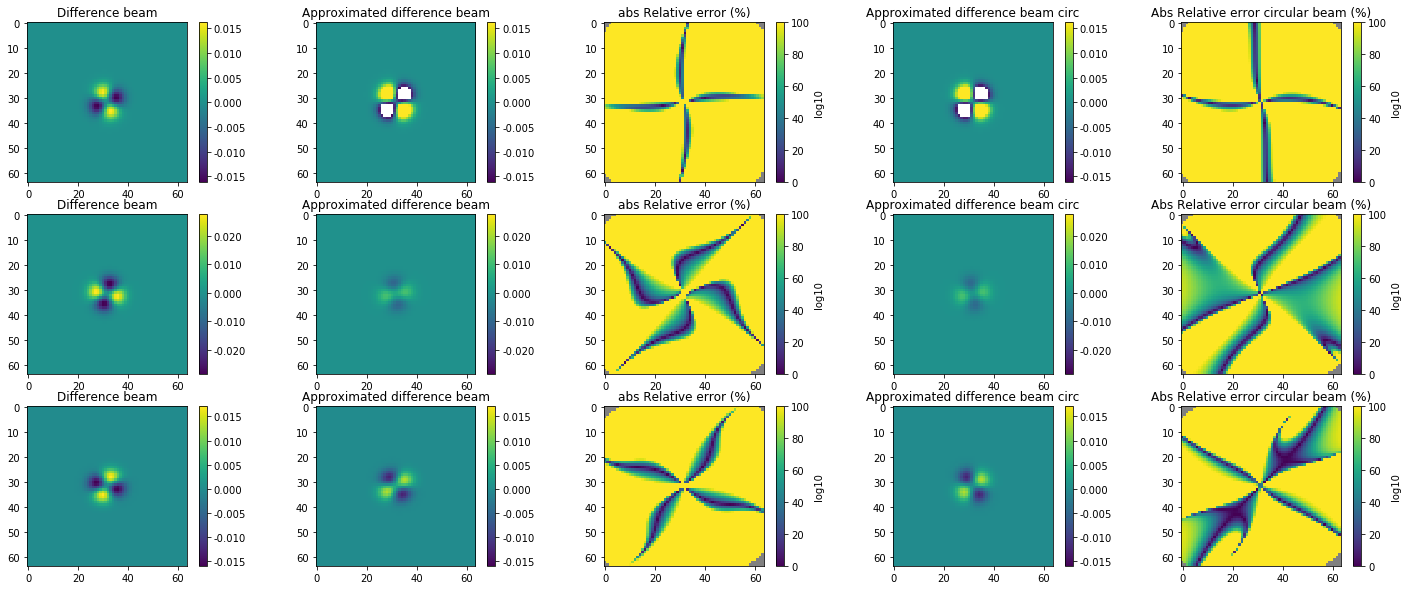

In [24]:
# default pix size for leakage calculation is 1/7 of FWHM
pix_size = inst.beam_model.fwhm / 7. / 60. * np.pi / 180.
nx = 64

#compute circular beam and its derivative to compare expansions on sumbeam and circular beam approximation
fwhm = inst.beam_model.fwhm*np.pi/180./60
xy2f = coordinates_on_grid(pix_size=pix_size, nx=nx)
circ_beam = gauss2d(xy2f,0,0, 1, fwhm/np.sqrt(8*np.log(2)), fwhm/np.sqrt(8*np.log(2)),0).reshape((nx, nx))
der_circ = derivs(circ_beam, pix_size)
der_circ = der_circ.reshape((6, circ_beam.shape[0] * circ_beam.shape[1]))
    
fig,ax = pl.subplots(3,5,figsize=(25,10))
for i in range(3):
    detid = 2*i+10 # pick random detectors in the focalplane
    
    ## Compute sum and diff beam map for the chosen pair
    summap, diffmap = construct_beammap(inst.beam_model, detid, detid+1, nx, pix_size)
    
    ## Compute derivative of sumbeam 
    der = derivs(summap, pix_size)
    der = der.reshape((6, summap.shape[0] * summap.shape[1]))
    
    ## Compute approximate beam using expansion on derivatives on the sum beam 
    ## and relative error w.r.t. to the true diffbeam    
    diffmap_approx = np.dot(Ktot[i][0], der).reshape((nx, nx))
    rel=(diffmap - diffmap_approx)/diffmap*100

    ## Compute approximate diffbeam using expansion on derivatives on the Gaussian circular beam
    ## and relative error w.r.t. to the true diffbeam
    diffmap_approx2 = np.dot(Ktot_diff[i][0], der_circ).reshape((nx, nx))
    rel2=(diffmap - diffmap_approx2)/diffmap*100
    
    obj1 = ax[i, 0].imshow(diffmap, vmin=np.min(diffmap), vmax=np.max(diffmap), aspect='equal')
    ax[i, 0].set_title('Difference beam')
    fig.colorbar(obj1, ax=ax[i, 0],orientation='vertical', shrink=1., format='%.3f')
    
    obj2 = ax[i, 1].imshow(diffmap_approx, vmin=np.min(diffmap), vmax=np.max(diffmap), aspect='equal')
    ax[i, 1].set_title('Approximated difference beam')
    fig.colorbar(obj2, ax=ax[i, 1],orientation='vertical', shrink=1., format='%.3f')
    
    obj3 = ax[i, 2].imshow(np.abs(rel),vmin=0, vmax=100, aspect='equal')
    ax[i,2].set_title('abs Relative error (%)')
    fig.colorbar(obj3, ax=ax[i, 2],orientation='vertical', shrink=1., format='%.0f',label='log10')
    
    obj4 = ax[i, 3].imshow(diffmap_approx2, vmin=np.min(diffmap), vmax=np.max(diffmap), aspect='equal')
    ax[i, 3].set_title('Approximated difference beam circ')
    fig.colorbar(obj4, ax=ax[i, 3], orientation='vertical', shrink=1., format='%.3f')
    
    
    obj5 = ax[i, 4].imshow(np.abs(rel2), vmin=0, vmax=100, aspect='equal')
    ax[i,4].set_title('Abs Relative error circular beam (%)')
    fig.colorbar(obj5, ax=ax[i, 4], orientation='vertical', shrink=1., format='%.0f',label='log10')
    
    # debug printout with ratio of sum of relative errors and ellipticities
    #print(np.sum(np.abs(rel2[(rel2==rel2) & np.isfinite(rel2)])**2)/np.sum(np.abs(rel[(rel==rel) & np.isfinite(rel)]))**2)
    #et=(inst.beam_model.sig_1[detid]-inst.beam_model.sig_2[detid])/(inst.beam_model.sig_1[detid]+inst.beam_model.sig_2[detid])
    #eb=(inst.beam_model.sig_1[detid+1]-inst.beam_model.sig_2[detid+1])/(inst.beam_model.sig_1[detid+1]+inst.beam_model.sig_2[detid+1])
    #print(et,eb)
pl.show()


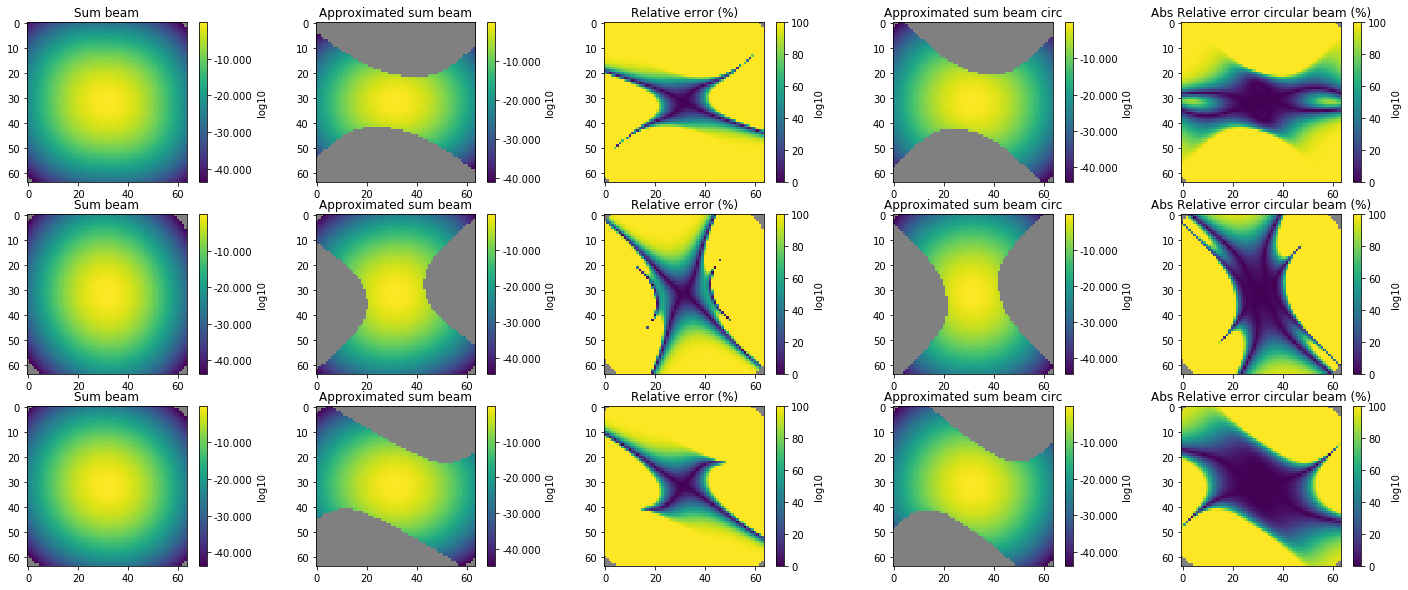

In [25]:
#same as above for the sum beam 
pix_size = 3.5 / 7. / 60. * np.pi / 180.
np.seterr(divide='ignore',invalid='ignore')
fig,ax = pl.subplots(3,5,figsize=(25,10))

for i in range(3):
    summap, diffmap = construct_beammap(inst.beam_model, 2*i, 2*i+1, nx, pix_size)
    #print(Ktot_sum[i][0])
    #print(Ktot_diff[i][0])
    #print(Ktot[i][0])
    
    ## Compute approximate sum beam using expansion on derivatives of the sum beam 
    ## and relative error w.r.t. to the true sumbeam    
    summap_approx = np.dot(Ktot_sum[i][0], der).reshape((nx, nx))
    rel=(summap - summap_approx)/summap*100    
    ## Compute approximate sum beam using expansion on derivatives of the circula Gaussian beam
    ## and relative error w.r.t. to the true sumbeam        
    summap_approx2 = np.dot(Ktot_sum[i][0], der_circ).reshape((nx, nx))
    rel2=(summap - summap_approx2)/summap*100    
    
    obj1 = ax[i, 0].imshow(np.log10(summap), aspect='equal')
    ax[i, 0].set_title('Sum beam')
    fig.colorbar(obj1, ax=ax[i, 0],orientation='vertical', shrink=1., format='%.3f',label='log10')
    
    obj2 = ax[i, 1].imshow(
    #    summap_approx, vmin=np.min(summap), vmax=np.max(summap), aspect='equal')
         np.log10(summap_approx), aspect='equal')
    ax[i, 1].set_title('Approximated sum beam')
    fig.colorbar(obj2, ax=ax[i, 1], orientation='vertical', shrink=1., format='%.3f',label='log10')
    
    obj3 = ax[i, 2].imshow(np.abs(rel), vmin=0,vmax=100,aspect='equal')
    ax[i,2].set_title('Relative error (%)')
    fig.colorbar(obj3, ax=ax[i, 2], orientation='vertical', shrink=1., format='%.0f',label='log10')

    obj4 = ax[i, 3].imshow(np.log10(summap_approx2),aspect='equal')#, vmin=np.min(diffmap), vmax=np.max(diffmap), 
    ax[i, 3].set_title('Approximated sum beam circ')
    fig.colorbar(obj4, ax=ax[i, 3], orientation='vertical', shrink=1., format='%.3f',label='log10')
    
    
    obj5 = ax[i, 4].imshow(np.abs(rel2), vmin=0, vmax=100, aspect='equal')
    ax[i,4].set_title('Abs Relative error circular beam (%)')
    fig.colorbar(obj5, ax=ax[i, 4], orientation='vertical', shrink=1., format='%.0f',label='log10')    

pl.show()

In [7]:
# set parameters for Noiseless simulations
array_noise_level = 0.0
state_for_noise = np.random.RandomState(3)
seeds_for_noise = state_for_noise.randint(0, 1e6, scan.nces)

#define plotting routines

def plot_leakage_maps(sky_in,sky, xsize=700,reso=6.9,xsize_leak=None):
    if xsize_leak is None:
        xsize_leak = xsize
        
    fig = pl.figure(figsize=(10, 15))

    nhit = partial2full(sky.nhit, sky.obspix, sky.nside, fill_with=0.0)
    
    ## Temperature
    sky_out = partial2full(sky.get_I(),sky.obspix,sky.nside, fill_with=0.0)

    mask = nhit < 1
    sky_out[mask] = np.nan

    hp.gnomview(sky_in.I, rot=[0, -57.5], xsize=xsize, reso=6.9, sub=331, 
            title='Input I', notext=True, min=-250, max=250)
    hp.gnomview(sky_out, rot=[0, -57.5], xsize=xsize, reso=6.9, sub=332, 
            title='Output I', notext=True, min=-250, max=250)
    hp.gnomview(sky_in.I - sky_out, rot=[0, -57.5], 
            xsize=xsize_leak, reso=6.9, sub=333, 
            title='Difference', notext=True)

    ## Stokes Q
    sky_out = partial2full(sky.get_QU()[0], sky.obspix, sky.nside, fill_with=0.0)

    mask = nhit < 10
    sky_out[mask] = np.nan

    hp.gnomview(sky_in.Q, rot=[0, -57.5], xsize=xsize, reso=6.9, sub=334, 
            title='Input Q',notext=True, min=-15, max=15)
    hp.gnomview(sky_out, rot=[0, -57.5], xsize=xsize, reso=6.9, sub=335,  
            title='Output Q',notext=True, min=-15, max=15)
    hp.gnomview(sky_in.Q - sky_out, rot=[0, -57.5], 
            xsize=xsize_leak, reso=6.9, sub=336, 
            notext=True, title='Difference', min=-0.15, max=0.15)

    ## Stokes U
    sky_out = partial2full(sky.get_QU()[1],sky.obspix, sky.nside, fill_with=0.0)

    mask = nhit < 10
    sky_out[mask] = np.nan

    hp.gnomview(sky_in.U, rot=[0, -57.5], xsize=xsize, reso=6.9, sub=337, 
            title='Input U',notext=True, min=-15, max=15)
    hp.gnomview(sky_out, rot=[0, -57.5], xsize=xsize, reso=6.9, sub=338, 
            title='Output U',notext=True, min=-15, max=15)
    hp.gnomview(sky_in.U - sky_out, rot=[0, -57.5], 
            xsize=xsize_leak, reso=6.9, sub=339, 
            title='Difference', notext=True, min=-0.15, max=0.15)
    pl.show()
    return

def plot_coverage(sky, xsize=700,reso=6.9):
    fig = pl.figure(figsize=(10, 5))

    nhit = partial2full(sky.nhit, sky.obspix, sky.nside, fill_with=0.0)
    det = partial2full( (sky.cc*sky.ss) - (sky.cs**2), sky.obspix, sky.nside, fill_with=0.0)
    cs = partial2full(sky.cs, sky.obspix, sky.nside, fill_with=0.0)
    
    
    ## Temperature
    sky_out = partial2full(sky.get_I(),sky.obspix,sky.nside, fill_with=0.0)

    mask = nhit < 1
    nhit[mask] = np.nan
    det[mask] = np.nan
    cs[mask] = np.nan
    
    hp.gnomview(nhit, rot=[0, -57.5], xsize=xsize, reso=6.9, sub=131, 
            title='Nhits', notext=True)
    hp.gnomview(det, rot=[0, -57.5], xsize=xsize, reso=6.9, sub=132, 
            title='Polarization block determinant', notext=True,)
    hp.gnomview(cs, rot=[0, -57.5], 
            xsize=xsize, reso=6.9, sub=133, 
            title='$<cos2\psi sin2\psi>$', notext=True)   
    pl.show()
    return

## Including leakage in mapmaking ## 

The following examples show how to compute leakages due to differential ellipticity properties in the maps.Examples incude :
* T->P leakage due to differential beam properties including or not monopole leakage
* P->T leakage due to differential beam properties including or not monopole leakage
* T->T, P->P distortion due to differential beam parameters (sum beam distortion, including or not the monopole component.

### Examples

In [30]:
## Loop over scans
for CESnumber in range(scan.nces):
    ## Note that we specify that we want to map pairs
    ## one-by-one by setting mapping_perpair to True. This is 
    ## very useful if you have no det-to-det correlations and 
    ## you want to save memory by not storing all timestreams
    ## in the memory.
    tod = TimeOrderedDataPairDiff(
        inst, scan, sky_in, CESnumber=CESnumber, 
        projection='healpix', 
        nside_out=nside, 
        width=130.,
        array_noise_level=array_noise_level,
        array_noise_seed=seeds_for_noise[CESnumber],
        mapping_perpair=True)
    
    ## Initialise map containers
    if CESnumber == 0:
        sky = OutputSkyMap(
            projection=tod.projection, 
            nside=tod.nside_out, 
            obspix=tod.obspix)
        intensity_derivatives = np.array(
            [sky_in.I[tod.obspix], sky_in.dIdt[tod.obspix], sky_in.dIdp[tod.obspix], 
             sky_in.d2Idpdt[tod.obspix], sky_in.d2Id2t[tod.obspix], sky_in.d2Id2p[tod.obspix]])
    
    ## Scan input map to get TODs
    ## Do it pair-by-pair to save memory for large runs.
    for i,pair in enumerate(tqdm(tod.pair_list)):
        ## Get the TOD
        d = np.array([tod.map2tod(det) for det in pair])
        
        ## Compute beam kernel coefficients. This notebook uses by default the 
        ## expansion on the derivatives of the circular beam used for the
        ## convolution of the input map. Check the code for supported alternative options.
        Kdiff = get_kernel_coefficients(inst.beam_model, [pair], kernel_type='diff')
        
        ## Get spurious signal from beam mismatch
        beam_orientation = tod.return_parallactic_angle(pair[0])
        waferts_add_diffbeam(
            waferts=d, 
            point_matrix=tod.point_matrix, 
            beam_orientation=beam_orientation,
            intensity_derivatives=intensity_derivatives, 
            diffbeam_kernels=Kdiff,
            pairlist=pair, 
            spins='012',kernel_type='diff_nomonopole')
        
        ## Project TOD to maps
        tod.tod2map(d, sky)


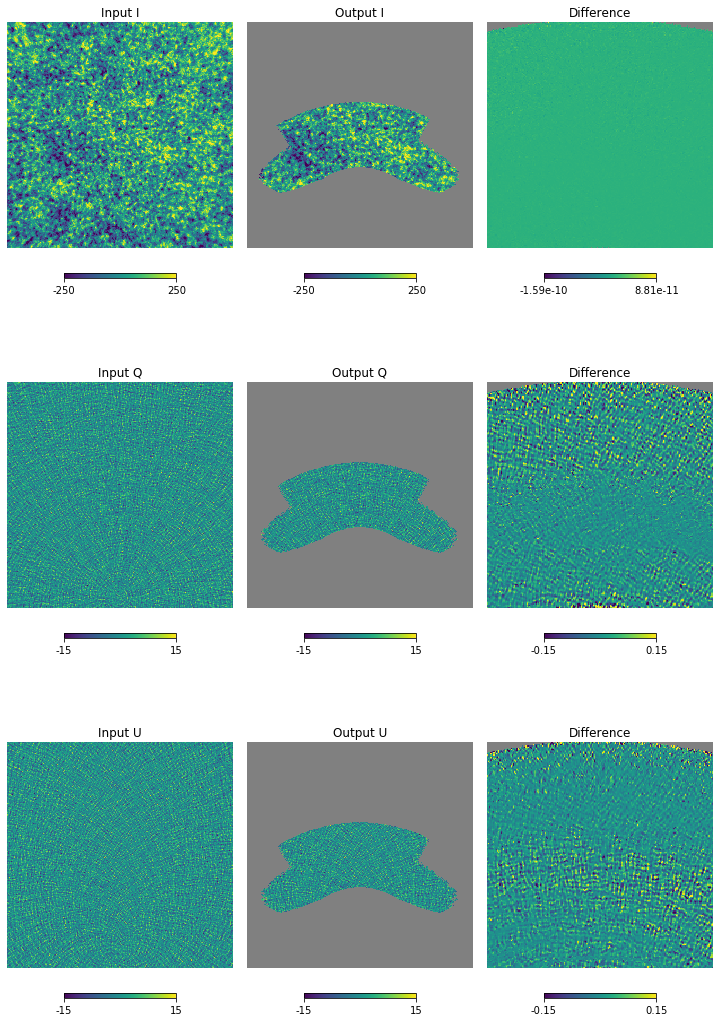

In [31]:
plot_leakage_maps(sky_in,sky, xsize=700,reso=6.9,xsize_leak=200)

Since the residual depends on the cross-linkning of the pixels, you can display the cross linking using this function
A low polarization block determinant means pixels are badly condition and we expect higher residual leakage
For badly observed pixels, Q and U are correlated and a measurement of this correlation is given by the
amplitude of the off diagonal term in the polarization block, i.e. <cos2\psi sin2\psi>, where <> indicates the
average over samples and psi the polarization angle



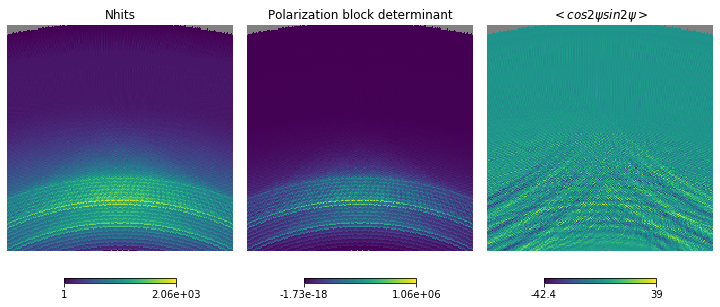

In [32]:
plot_coverage(sky,200)

You can add the monopole leakage removing the _nomonopole string in the kernel definition. You can see
that the leakage now is dominated by a structure that ressembles more the T map while the T maps itself
is still unaffected.


In [34]:

## Loop over scans
for CESnumber in range(scan.nces):
    ## Note that we specify that we want to map pairs
    ## one-by-one by setting mapping_perpair to True. This is 
    ## very useful if you have no det-to-det correlations and 
    ## you want to save memory by not storing all timestreams
    ## in the memory.
    tod = TimeOrderedDataPairDiff(
        inst, scan, sky_in, CESnumber=CESnumber, 
        projection='healpix', 
        nside_out=nside, 
        width=130.,
        array_noise_level=array_noise_level,
        array_noise_seed=seeds_for_noise[CESnumber],
        mapping_perpair=True)
    
    ## Initialise map containers
    if CESnumber == 0:
        sky = OutputSkyMap(
            projection=tod.projection, 
            nside=tod.nside_out, 
            obspix=tod.obspix)
        intensity_derivatives = np.array(
            [sky_in.I[tod.obspix], sky_in.dIdt[tod.obspix], sky_in.dIdp[tod.obspix], 
             sky_in.d2Idpdt[tod.obspix], sky_in.d2Id2t[tod.obspix], sky_in.d2Id2p[tod.obspix]])
    
    ## Scan input map to get TODs
    ## Do it pair-by-pair to save memory for large runs.
    for i,pair in enumerate(tqdm(tod.pair_list)):
        ## Get the TOD
        d = np.array([tod.map2tod(det) for det in pair])
        
        Kdiff = get_kernel_coefficients(inst.beam_model, [pair],kernel_type='diff')
        
        ## Get spurious signal from beam mismatch
        beam_orientation = tod.return_parallactic_angle(pair[0])
        waferts_add_diffbeam(
            waferts=d, 
            point_matrix=tod.point_matrix, 
            beam_orientation=beam_orientation,
            intensity_derivatives=intensity_derivatives, 
            diffbeam_kernels=Kdiff,
            pairlist=pair, 
            spins='012',kernel_type='diff')
        
        ## Project TOD to maps
        tod.tod2map(d, sky)


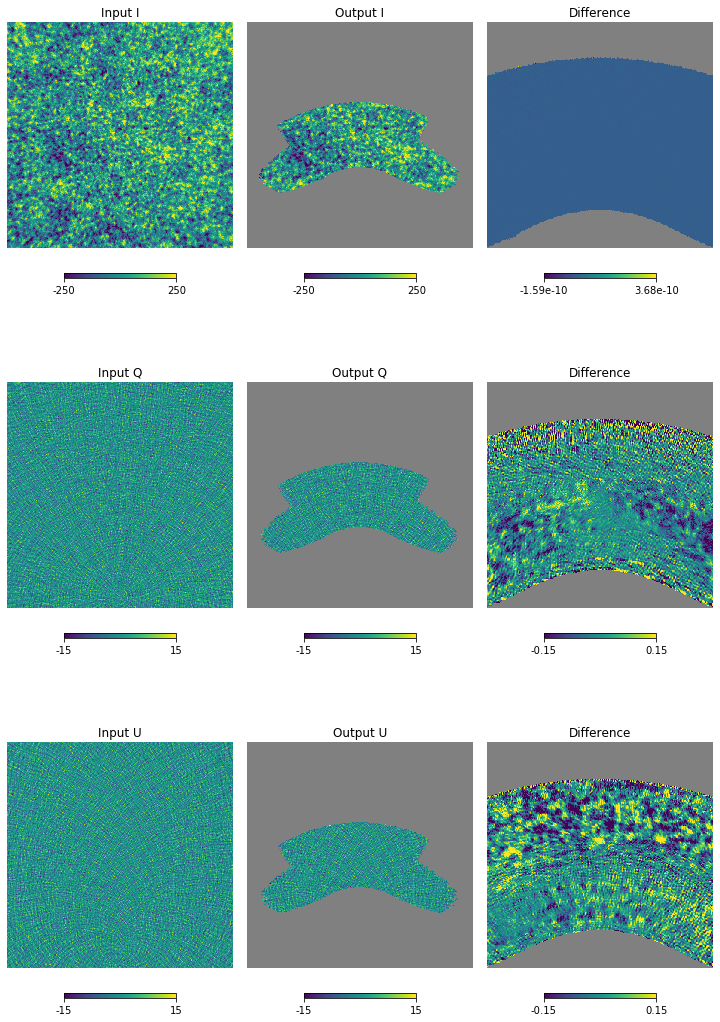

In [35]:
plot_leakage_maps(sky_in,sky, xsize=700,reso=6.9,xsize_leak=300)

In this example we inject sum leakage due do beam distortions on temperature only. As done above you can remove the 
"_nomonopole" part to include the monopole leakage.

In [37]:

## Loop over scans
for CESnumber in range(scan.nces):
#for CESnumber in range(1):
    ## Note that we specify that we want to map pairs
    ## one-by-one by setting mapping_perpair to True. This is 
    ## very useful if you have no det-to-det correlations and 
    ## you want to save memory by not storing all timestreams
    ## in the memory.
    tod = TimeOrderedDataPairDiff(
        inst, scan, sky_in, CESnumber=CESnumber, 
        projection='healpix', 
        nside_out=nside, 
        width=130.,
        array_noise_level=array_noise_level,
        array_noise_seed=seeds_for_noise[CESnumber],
        mapping_perpair=True)
    
    ## Initialise map containers
    if CESnumber == 0:
        sky = OutputSkyMap(
            projection=tod.projection, 
            nside=tod.nside_out, 
            obspix=tod.obspix)
        # ATTENTION derivatives objects need to be constructed only for the observed pixel in the 
        # field. 
        intensity_derivatives = np.array(
            [sky_in.I[tod.obspix], sky_in.dIdt[tod.obspix], sky_in.dIdp[tod.obspix], 
             sky_in.d2Idpdt[tod.obspix], sky_in.d2Id2t[tod.obspix], sky_in.d2Id2p[tod.obspix]])
        
    ## Scan input map to get TODs
    ## Do it pair-by-pair to save memory for large runs.
    for i,pair in enumerate(tqdm(tod.pair_list)):
        ## Get the TOD
        d = np.array([tod.map2tod(det) for det in pair])
        
        ## Compute beam kernel coefficients expandend on the circular beam approximation
        Ksum = get_kernel_coefficients(inst.beam_model,[pair],kernel_type='sum')
        
        ## Get spurious signal from beam mismatch
        beam_orientation = tod.return_parallactic_angle(pair[0])
        waferts_add_diffbeam(
            waferts=d, 
            point_matrix=tod.point_matrix, 
            beam_orientation=beam_orientation,
            intensity_derivatives=intensity_derivatives, 
            diffbeam_kernels=Ksum,
            pairlist=pair, 
            spins='012',kernel_type='sum_nomonopole')
        
        ## Project TOD to maps
        tod.tod2map(d, sky)

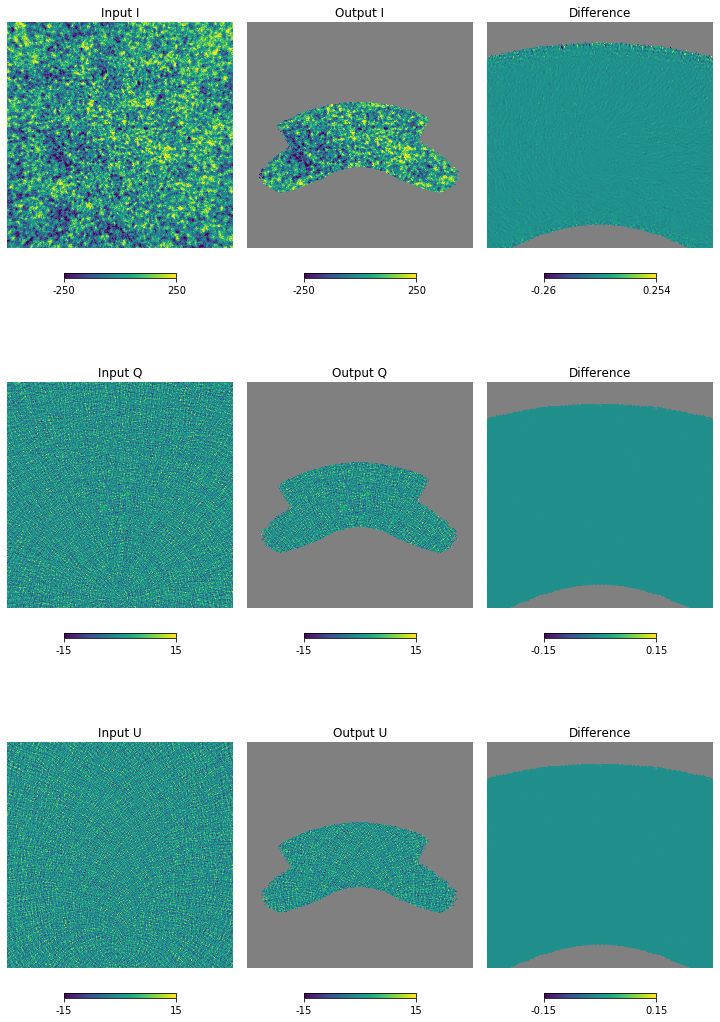

In [38]:
plot_leakage_maps(sky_in,sky, xsize=700,reso=6.9,xsize_leak=250)

In the cell below we make an example including polarization and monopole leakage. Note you can specify 
different type of spin terms to be included in temperature and polarization wiht the spins_pol keyword.
with sum leakage you will inlude I->I (and P->P if you provide polarization derivatives).
with diff leakage you will inlude I->P (and P->I if you provide polarization derivatives).

In [8]:
for CESnumber in range(scan.nces):
    tod = TimeOrderedDataPairDiff(
        inst, scan, sky_in, CESnumber=CESnumber, 
        projection='healpix', 
        nside_out=nside, 
        width=130.,
        array_noise_level=array_noise_level,
        array_noise_seed=seeds_for_noise[CESnumber],
        mapping_perpair=True)
    
    ## Initialise map containers
    if CESnumber == 0:
        sky = OutputSkyMap(
            projection=tod.projection, 
            nside=tod.nside_out, 
            obspix=tod.obspix)
        # ATTENTION derivatives objects need to be constructed only for the observed pixel in the 
        # field. 
        intensity_derivatives = np.array(
            [sky_in.I[tod.obspix], sky_in.dIdt[tod.obspix], sky_in.dIdp[tod.obspix], 
             sky_in.d2Idpdt[tod.obspix], sky_in.d2Id2t[tod.obspix], sky_in.d2Id2p[tod.obspix]])
        
        # ATTENTION polarization derivatives are not supported by healpix. For the purpose of this
        # toy example we assumed the are 1/10 of the intensity derivatives.
        q_derivatives = [i/10 for i in intensity_derivatives]
        u_derivatives = q_derivatives
        pol_derivatives=[q_derivatives,u_derivatives]
    
    ## Scan input map to get TODs
    ## Do it pair-by-pair to save memory for large runs.
    for i,pair in enumerate(tqdm(tod.pair_list)):
        ## Get the TOD
        d = np.array([tod.map2tod(det) for det in pair])
        
        Kdiff,K = get_kernel_coefficients(inst.beam_model, [pair],kernel_type='sumdiff')
        
        ## Get spurious signal from beam mismatch
        ## Usign is useful only if flat sky simulations are carried out and it takes
        ## care of injecting the U leakage witht he correct sign as it differs from the 
        ## Healpix convention. Same syntax applies for diff kernels to inject P_I leakage
        beam_orientation = tod.return_parallactic_angle(pair[0])
        waferts_add_diffbeam(
            waferts=d, 
            point_matrix=tod.point_matrix, 
            beam_orientation=beam_orientation,
            intensity_derivatives=intensity_derivatives, 
            diffbeam_kernels=K,
            pairlist=pair, 
            spins='012',kernel_type='sum',pol_derivatives=[intensity_derivatives,intensity_derivatives],pol_angle=tod.pol_angs,Usign=tod.Usign)
        
        ## Project TOD to maps
        tod.tod2map(d, sky)      

Pixels outside patch boundaries. Your output map will be cropped. To avoid this, increase the parameter width while initialising the TOD.


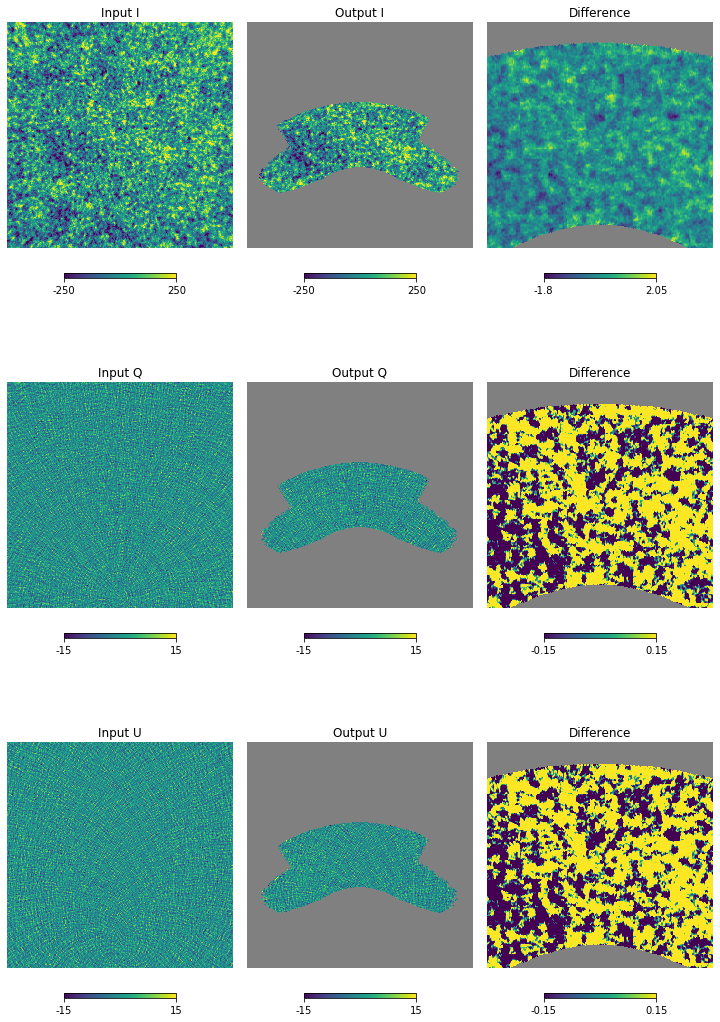

In [9]:
plot_leakage_maps(sky_in,sky, xsize=700,reso=6.9,xsize_leak=250)  

## Beam derivatives comparison 
Below we show a comparison between the derivatives of the sum beam (perturbed) and the derivative of the
circular gaussian one used for the examples. 
Developing the sum beam on the sum beam derivatives instead of the circular beam, should introduce minor 
differences.

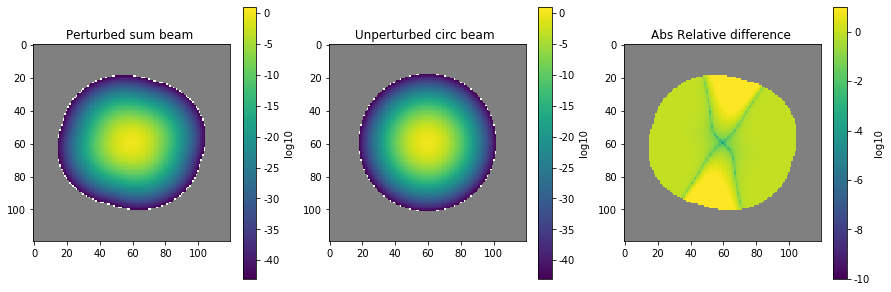

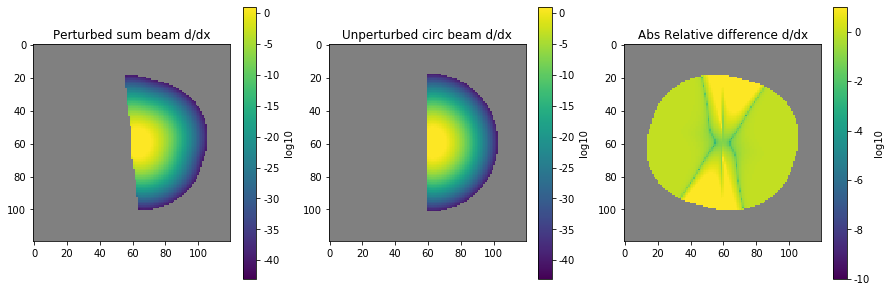

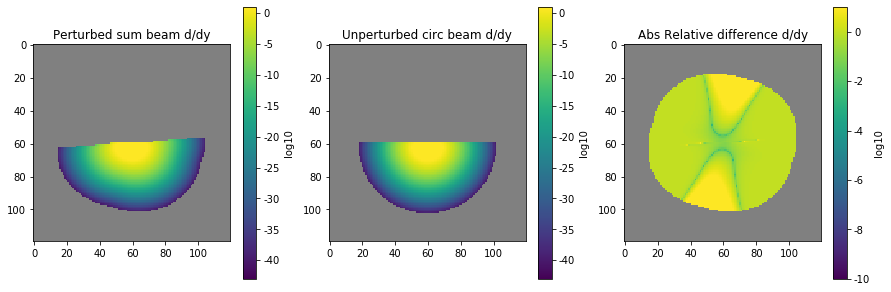

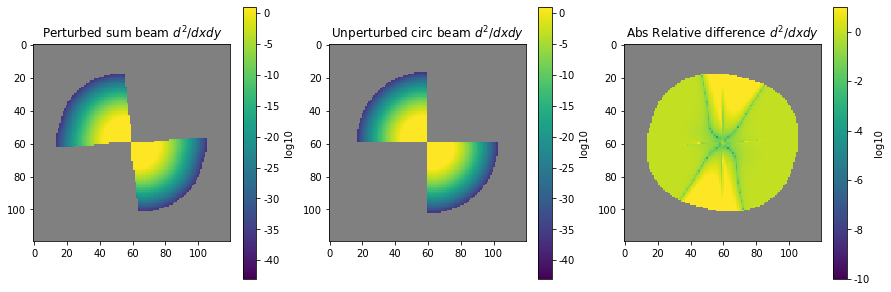

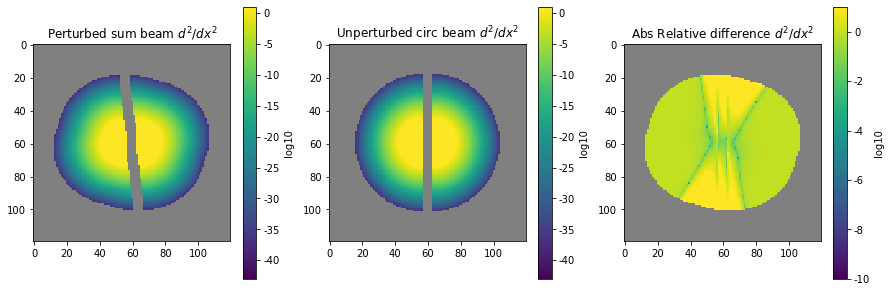

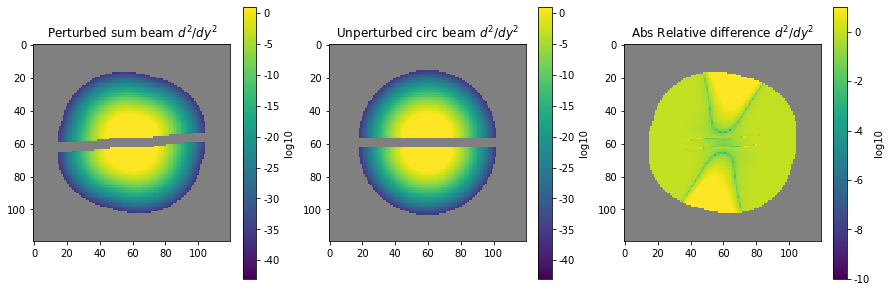

In [99]:
## Visualisation setup
pix_size = 0.5 / 60. * np.pi / 180.
nx=120

# pair beams used for the example
ct=30
cb=31

# compute sum beam and its derivatives
summap, diffmap = construct_beammap(inst.beam_model, ct,cb, nx, pix_size)
der_sum = derivs(summap,pix_size=pix_size)


# compute circular Gaussian beam and its derivatives 
fwhm = inst.beam_model.fwhm*np.pi/180./60
xy2f = coordinates_on_grid(pix_size=pix_size, nx=nx)
circ_beam = gauss2d(xy2f,0,0, 1, fwhm/np.sqrt(8*np.log(2)), fwhm/np.sqrt(8*np.log(2)),0).reshape((nx, nx))
der_circ = derivs(circ_beam,pix_size=pix_size)
titles = ['','d/dx','d/dy','$d^2/dxdy$','$d^2/dx^2$','$d^2/dy^2$']
for i in range(6):
    fig, ax = pl.subplots(1, 3, figsize=(15, 5))

    obj1=ax[0].imshow(np.log10(der_sum[i]), vmin=-43, vmax=1)
    ax[0].set_title('Perturbed sum beam %s'%titles[i])
    obj2=ax[1].imshow(np.log10(der_circ[i]), vmin=-43, vmax=1)
    ax[1].set_title('Unperturbed circ beam %s'%titles[i])
    obj3=ax[2].imshow(np.log10(np.abs(der_circ[i]/der_sum[i] -1)), vmin=-10, vmax=1)
    ax[2].set_title('Abs Relative difference %s'%titles[i])    
    fig.colorbar(obj1, ax=ax[0], orientation='vertical', shrink=1., format='%.0f',label='log10')
    fig.colorbar(obj2, ax=ax[1], orientation='vertical', shrink=1., format='%.0f',label='log10')
    fig.colorbar(obj3, ax=ax[2], orientation='vertical', shrink=1., format='%.0f',label='log10')
    pl.show()


We can do the same for the diff beam. Some part of the beam are cut because they are negative

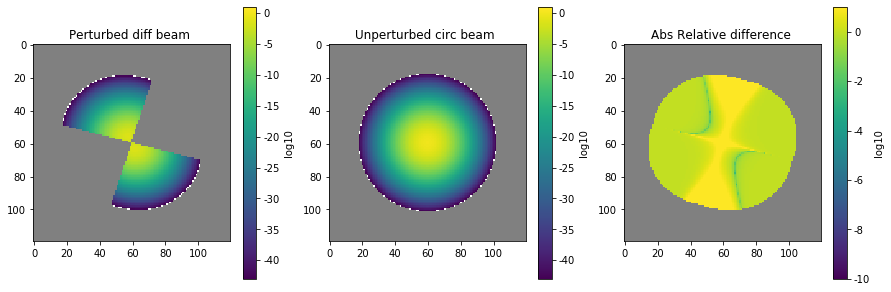

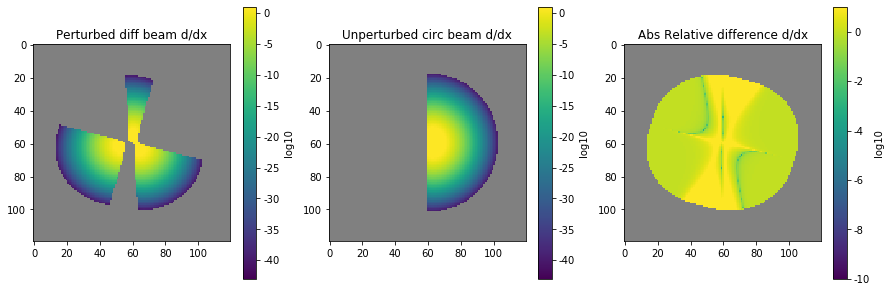

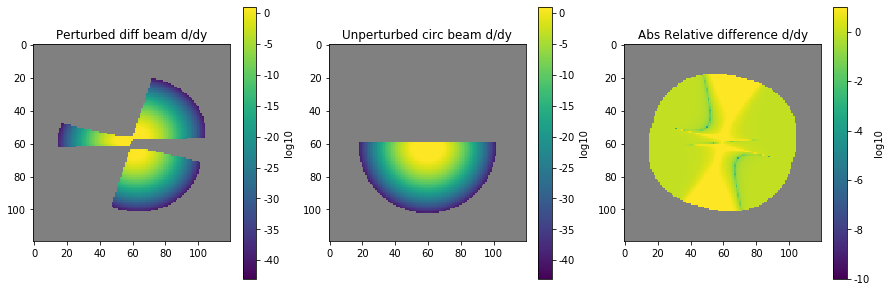

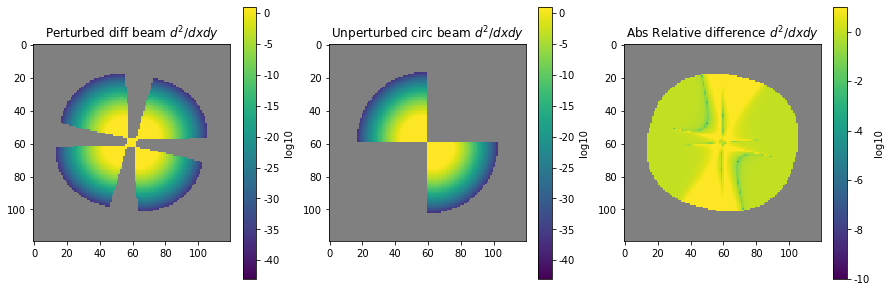

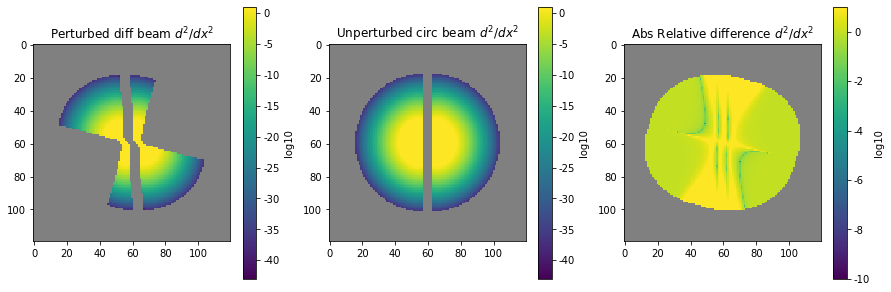

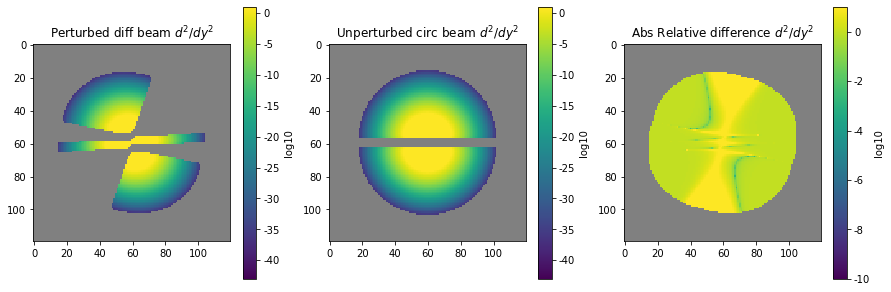

In [102]:
## Visualisation setup
pix_size = 0.5 / 60. * np.pi / 180.
nx=120

# pair beams used for the example
ct=30
cb=31

# compute sum beam and its derivatives
summap, diffmap = construct_beammap(inst.beam_model, ct,cb, nx, pix_size)
der_diff= derivs(diffmap,pix_size=pix_size)


# compute circular Gaussian beam and its derivatives 
fwhm = inst.beam_model.fwhm*np.pi/180./60
xy2f = coordinates_on_grid(pix_size=pix_size, nx=nx)
circ_beam = gauss2d(xy2f,0,0, 1, fwhm/np.sqrt(8*np.log(2)), fwhm/np.sqrt(8*np.log(2)),0).reshape((nx, nx))
der_circ = derivs(circ_beam,pix_size=pix_size)
titles = ['','d/dx','d/dy','$d^2/dxdy$','$d^2/dx^2$','$d^2/dy^2$']
for i in range(6):
    fig, ax = pl.subplots(1, 3, figsize=(15, 5))

    obj1=ax[0].imshow(np.log10(der_diff[i]), vmin=-43, vmax=1)
    ax[0].set_title('Perturbed diff beam %s'%titles[i])
    obj2=ax[1].imshow(np.log10(der_circ[i]), vmin=-43, vmax=1)
    ax[1].set_title('Unperturbed circ beam %s'%titles[i])
    obj3=ax[2].imshow(np.log10(np.abs(der_circ[i]/der_diff[i] -1)), vmin=-10, vmax=1)
    ax[2].set_title('Abs Relative difference %s'%titles[i])    
    fig.colorbar(obj1, ax=ax[0], orientation='vertical', shrink=1., format='%.0f',label='log10')
    fig.colorbar(obj2, ax=ax[1], orientation='vertical', shrink=1., format='%.0f',label='log10')
    fig.colorbar(obj3, ax=ax[2], orientation='vertical', shrink=1., format='%.0f',label='log10')
    pl.show()